In [1]:
import xarray as xr
import scipy.optimize
import numpy as np
import matplotlib.pyplot as plt
import warnings
import os
from tqdm.notebook import tqdm
from cartopy.util import add_cyclic_point
import matplotlib.colors as mcolors
from matplotlib.offsetbox import TextArea, HPacker, AnnotationBbox

from isca_tools.cesm import get_pressure
from isca_tools.convection.base import lcl_sigma_bolton_simple
import cartopy.crs as ccrs
from isca_tools.plot import fig_resize, update_fontsize, update_linewidth, savefig, label_subplots
from isca_tools.utils import area_weighting, print_ds_var_list
from isca_tools.utils.base import round_any
from isca_tools.utils.constants import L_v, c_p, g, R, kappa, lapse_dry, temp_kelvin_to_celsius
from isca_tools.thesis.mod_parcel_theory import get_temp_mod_parcel, get_scale_factor_theory_numerical2, \
    get_scale_factor_theory, get_sensitivity_factors
from isca_tools.thesis.adiabat_theory2 import get_cape_approx
from isca_tools.utils.decomposition import scaled_k_means_single
from isca_tools.utils.ds_slicing import fold_coarsen
from isca_tools.utils.moist_physics import moist_static_energy, sphum_sat
from isca_tools.utils.xarray import wrap_with_apply_ufunc, isel_float
import jobs.theory_lapse.cesm.thesis_figs.scripts.utils as utils

warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
width = {'one_col': 3.2, 'two_col': 5.5}  # width in inches
im_sz = 1.5
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')
ax_linewidth = plt.rcParams['axes.linewidth']
leg_handlelength = 1.5

## Load data and average over `lon_sample` dimension
We average over all days for which the convective threshold is satisfied.

For `ds_ref` quantities, we average over all convective days. For `ds_quant`, we average over all convective days separately for each temperature quantile, $x$. The variables $\chi[x]$ conditioned on $x$, are then computed from these variables, as was done in the previous scaling factor theory.

In [3]:
%%time
p_ft_use = 400 * 100
ds = []
with tqdm(total=len(utils.exp_names), position=0, leave=True) as pbar:
    for exp_name in utils.exp_names:
        ds.append(utils.load_ds(exp_name, 95,
                                var_keep=utils.vars_lapse_data).load().sel(p_ft=p_ft_use))
        pbar.update(1)
ds = xr.concat(ds, dim=xr.DataArray([utils.get_co2_multiplier(utils.exp_names[i])
                                     for i in range(len(ds))], dims="co2", name='co2'))
# ds = ds.sel(lat=slice(-45, 75))  # ignore antarctica and north pole
# ds = ds.drop_vars(['time', 'FSDS', 'FSNS'])
# Only keep land coords
from jobs.theory_lapse.cesm.thesis_figs.scripts.load_ds_tropics import land_frac_thresh

lsm = ds.LANDFRAC.isel(co2=0) > land_frac_thresh
ocean_mask = ds.LANDFRAC.isel(co2=0) == 0

# Chose best rh_mod
ds = utils.sel_best_rh_mod(ds)

  0%|          | 0/2 [00:00<?, ?it/s]

CPU times: user 34.9 s, sys: 6.62 s, total: 41.5 s
Wall time: 44.7 s


In [4]:
%%time
ds['p_lnb_approx'] = get_pressure(ds.PS, ds.P0, ds.hyam, ds.hybm).isel(lev=ds.lnb1_ind)
ds['lapse_Dz'] = ds.mod_parcel_lapse.isel(layer=0) / 1000 - lapse_dry
ds['lapse_Mz'] = ds.mod_parcel_lapse.isel(layer=1) / 1000
ds['lapse_D'] = R / g * ds.TREFHT * ds['lapse_Dz']
ds['lapse_M'] = R / g * ds.T_ft_env * ds['lapse_Mz']
lat_weights = utils.lat_weights.reindex_like(ds.lat)
temp_surf_lcl_calc = ds.temp_surf_lcl_calc
p_ft = float(ds.p_ft)

# Get rid of variables no longer need. Must remove those without lon, lat, sample in dimensions for fold_coarsen to work
drop_vars = ['hyam', 'hybm', 'lnb1_ind', 'LANDFRAC', 'const_lapse', 'mod_parcel_lapse']
ds = ds.drop_vars(drop_vars)

CPU times: user 266 ms, sys: 446 ms, total: 712 ms
Wall time: 798 ms


## Sanity check for convective definition
Below I compare % of days where convection scheme triggered (b) with % of days classified as convective in our regime.

Also, use to say only consider land as ocean no real convection outside tropics.

In [6]:
# Also avoid regions below freezing
ds['mask_conv'] = utils.get_valid_mask(ds) & (ds.TREFHT > temp_kelvin_to_celsius)
ds['lsm'] = (ds.TREFHT > 0).isel(co2=0) & lsm  # so lsm has sample dimension required for coarsening
ds['lat_weights'] = lat_weights.where((ds.TREFHT > 0).isel(co2=0))

In [8]:
def plot_scatter_mask(mask, ax, s=12, color='k', marker='.', zorder=20, edgecolors='None', linewidths=1.0):
    # Cyclic versions of BOTH data and mask along lon axis=1
    mask_c, lon_c = add_cyclic_point(mask.values.astype(int), coord=mask["lon"].values, axis=1)  # [web:66]
    mask_c = mask_c.astype(bool)

    # Scatter where True (now indices match lon_c)
    iy, ix = np.where(mask_c)

    lon_pts = lon_c[ix]
    lat_pts = mask["lat"].values[iy]

    return ax.scatter(lon_pts, lat_pts, transform=ccrs.PlateCarree(),
                      s=s, marker=marker, facecolors=color, edgecolors=edgecolors, zorder=zorder, linewidths=linewidths)

## Coarsen Grid
Below, I coarsen grid, and then consider regions for which there are atleast 50 valid days at that new larger grid point.
There is still a significant number of regions to do subsequent analysis.

Do that here so in convection point can indicate locations included.

In [9]:
lat_min = -45
lat_max = 75
n_coarse_lat = 4
n_coarse_lon = 4
ds_coarse = fold_coarsen(ds.sel(lat=slice(lat_min, lat_max)), k_lat=n_coarse_lat, k_lon=n_coarse_lon)
ds_coarse['mask_conv'] = ds_coarse['mask_conv'] & ds_coarse['lsm']  # only include land from now on
ds_coarse.attrs['temp_surf_lcl_calc'] = temp_surf_lcl_calc
ds_coarse.attrs['p_ft'] = p_ft
mask_loc = (ds_coarse.mask_conv.sum(dim='sample') > 400).all(dim='co2')  # choose where > 400 days

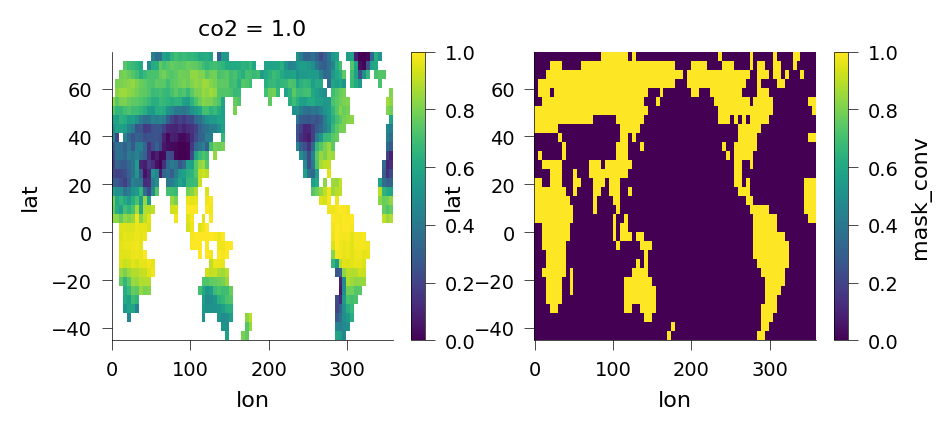

In [10]:
# % of land days convective
fig, ax = plt.subplots(1, 2)
fig_resize(fig, 5)
((ds_coarse.mask_conv).sum(dim='sample') / (ds_coarse.lsm).sum(dim='sample')).isel(co2=0).plot(ax=ax[0])
mask_loc.plot(ax=ax[1])
plt.show()

## x=50 scale factor vs local x=95 scale factor
Below I compare the spatial scale factor for the hottest 50% of days at each location with the local scaling factor obtained by comparing warming of hottest 5% to 50% of days at given location.

Put this in appendix.

In [168]:
ds_ref = xr.load_dataset(os.path.join(utils.out_dir, 'ds_quant50_av.nc'))
ds_ref = ds_ref.drop_vars(['hyam', 'hybm', 'P0', 'time_ind', 'gw'])
ds_ref['lat_weights'] = lat_weights.where((ds_ref.TREFHT > 0).isel(co2=0))
# Coarsen grid
ds_ref = fold_coarsen(ds_ref.sel(lat=slice(lat_min, lat_max)).expand_dims({'sample': [0]}), k_lat=n_coarse_lat,
                      k_lon=n_coarse_lon)
ds_ref_global_av = ds_ref.where(mask_loc).weighted(ds_ref.lat_weights).mean(dim=['sample', 'lat', 'lon'])
ds_ref_spatial = ds_ref.where(mask_loc).weighted(ds_ref.lat_weights).mean(dim='sample')

# So ref is parcel
ds_ref_spatial['lapse_M'] = ds_ref_spatial['PREFHT'] * 0
ds_ref_spatial['lapse_D'] = ds_ref_spatial['PREFHT'] * 0
ds_ref_spatial['rh_mod'] = ds_ref_spatial['PREFHT'] * 0

# So ref does not change relative humidity or pressure
ds_ref_spatial['rh_REFHT'] = ds_ref_spatial.rh_REFHT * 0 + ds_ref_spatial.rh_REFHT.isel(co2=0)
ds_ref_spatial['PREFHT'] = ds_ref_spatial.PREFHT * 0 + ds_ref_spatial.PREFHT.isel(co2=0)
# Set reference FT temperature to that following a parcel profile
ds_ref_spatial['T_ft_env'] = xr.apply_ufunc(get_temp_mod_parcel, ds_ref_spatial.rh_REFHT + ds_ref_spatial.rh_mod,
                                            ds_ref_spatial.PREFHT,
                                            p_ft, 0, 0, ds_ref_spatial['TREFHT'],
                                            input_core_dims=[[], [], [], [], [], []], vectorize=True,
                                            kwargs={'temp_surf_lcl_calc': temp_surf_lcl_calc})

# So ref is parcel
ds_ref_global_av['lapse_M'] = ds_ref_global_av['PREFHT'] * 0
ds_ref_global_av['lapse_D'] = ds_ref_global_av['PREFHT'] * 0
ds_ref_global_av['rh_mod'] = ds_ref_global_av['PREFHT'] * 0

In [98]:
# Uses quant=95 data
ds_spatial = ds_coarse.where(ds_coarse.mask_conv & mask_loc).weighted(ds_coarse.lat_weights).mean(dim='sample')
ds_spatial['rh_mod'] = ds.rh_mod[ds_coarse.mod_parcel_rh_mod_ind].where(ds_coarse.mask_conv & mask_loc
                                                                        ).weighted(ds_coarse.lat_weights).mean(
    dim='sample')
ds_spatial = ds_spatial.expand_dims({'quant': [95]})

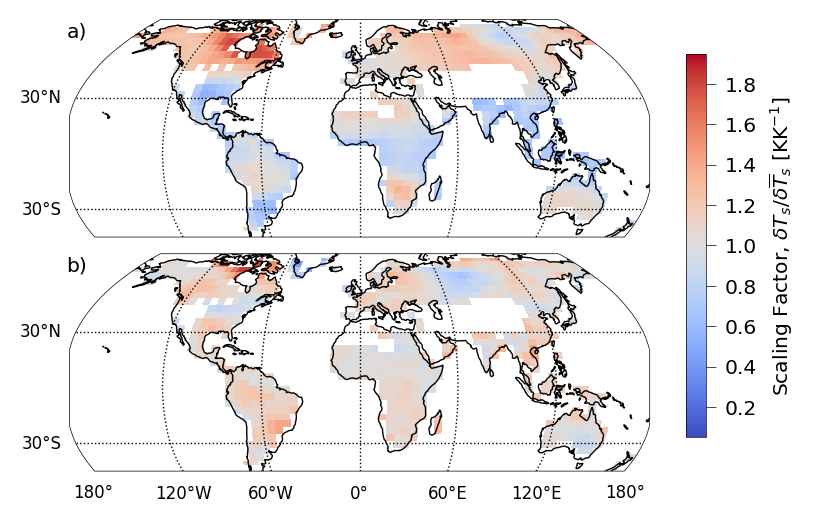

In [95]:
sf_quant50 = ds_ref_spatial.TREFHT.diff(dim='co2').squeeze() / ds_ref_global_av.TREFHT.diff(dim='co2').squeeze()
sf_quant95_local = ds_spatial.TREFHT.diff(dim='co2').squeeze() / ds_ref_spatial.TREFHT.diff(dim='co2').squeeze()

gl_fontsize = 6
sf_clim = [0.05, 1.95]
fig = plt.figure(constrained_layout=True)
ax = fig.subplots(2, 1, subplot_kw={'projection': ccrs.Robinson()}, gridspec_kw={'hspace': 0}, sharex=True, sharey=True)
fig_resize(fig, 10, ar=8)
for i, ax_use in enumerate(ax.flatten()):
    gl = utils.initialize_ax_projection(ax_use, lat_min=lat_min, lat_max=lat_max, grid_lat=[-30, 30], return_gl=True,
                                        coastline_lw=0.5, gridline_lw=0.5)[1]
    gl.xlabel_style = {"size": gl_fontsize}
    gl.ylabel_style = {"size": gl_fontsize}
    if i == 0:
        gl.bottom_labels = False
utils.plot_contour_projection(ax[0], sf_quant50.where(mask_loc), cmap='coolwarm',
                              imshow=True, imshow_kwargs={'vmin': sf_clim[0], 'vmax': sf_clim[1]})
im = utils.plot_contour_projection(ax[1], sf_quant95_local.where(mask_loc),
                                   cmap='coolwarm', imshow=True, imshow_kwargs={'vmin': sf_clim[0], 'vmax': sf_clim[1]})

label_subplots(fig, ax, box_alpha=0, pos_y=-1, pos_x=-1)
plt.colorbar(im, ax=ax.ravel(), label=utils.sf_label.replace('(x)', ''), shrink=0.85, ticks=np.arange(0.2, 2, 0.2),
             pad=0.02)
# ax[0, 0].set_title('Simulated', fontweight='bold')
# ax[0, 1].set_title('Theory', fontweight='bold')
# ax[1, 0].set_title('Theory - Change Mechanisms', fontweight='bold')
# ax[1, 1].set_title('Theory - Climatological Mechanisms', fontweight='bold')
update_fontsize(fig, base_fontsize=7)
plt.show()
# savefig(fig)

## Local Scaling factor decomposition
Below I plot the local x=95 vs x=50 scaling factor decomposition into mechanisms. However, because not all x>50 days are convective, this does not really make sense. You are comparing to hypothetical day which you assume to be following a moist adiabat.

Don't think should include this. Instead, just include spatial plot for the tropics.

In [239]:
%%time
comp_level = 4
out_path_sf = os.path.join(utils.out_dir, 'ds_sf_quant95_local.nc')
out_path_sf_num = os.path.join(utils.out_dir, 'ds_sf_quant95_local_num.nc')
if os.path.exists(out_path_sf):
    ds_sf = xr.load_dataset(out_path_sf).squeeze()
    print(f'Loaded ds_sf from {out_path_sf}')
else:
    ds_sf = []
if os.path.exists(out_path_sf_num):
    ds_sf_num = xr.load_dataset(out_path_sf_num).squeeze()
    print(f'Loaded ds_sf_num from {out_path_sf_num}')
else:
    ds_sf_num = []

with tqdm(total=ds_spatial.lat.size * ds_spatial.lon.size, position=0, leave=True) as pbar:
    for i in range(ds_spatial.lat.size):
        ds_sf_lat = []
        ds_sf_num_lat = []
        for j in range(ds_spatial.lon.size):
            if isinstance(ds_sf, list):
                ds_sf_lat.append(
                    utils.apply_sf_theory_with_rh_mod(ds_spatial.isel(lat=i, lon=j), ds_ref_spatial.isel(lat=i, lon=j),
                                                      p_ft, temp_surf_lcl_calc, quant_dim='quant', numerical=False))
            if isinstance(ds_sf_num, list):
                ds_sf_num_lat.append(
                    utils.apply_sf_theory_with_rh_mod(ds_spatial.isel(lat=i, lon=j), ds_ref_spatial.isel(lat=i, lon=j),
                                                      p_ft, temp_surf_lcl_calc, quant_dim='quant', numerical=True))
            pbar.update(1)
        if isinstance(ds_sf, list):
            ds_sf.append(xr.concat(ds_sf_lat, dim=ds_spatial.lon))
        if isinstance(ds_sf_num, list):
            ds_sf_num.append(xr.concat(ds_sf_num_lat, dim=ds_spatial.lon))
if isinstance(ds_sf, list):
    ds_sf = xr.concat(ds_sf, dim=ds_spatial.lat).squeeze()
    ds_sf.to_netcdf(out_path_sf, encoding={var: {"zlib": True, "complevel": comp_level} for var in ds_sf.data_vars})
    print(f'Saved ds_sf to {out_path_sf}')
if isinstance(ds_sf_num, list):
    ds_sf_num = xr.concat(ds_sf_num, dim=ds_spatial.lat)
    ds_sf_num.to_netcdf(out_path_sf_num, encoding={var: {"zlib": True, "complevel": comp_level} for var in ds_sf_num.data_vars})
    print(f'Saved ds_sf_num to {out_path_sf}')

Loaded ds_sf from /Users/joshduffield/Documents/StAndrews/Isca/jobs/theory_lapse/cesm/thesis_figs/ds_processed/ds_sf_quant95_local.nc
Loaded ds_sf_num from /Users/joshduffield/Documents/StAndrews/Isca/jobs/theory_lapse/cesm/thesis_figs/ds_processed/ds_sf_quant95_local_num.nc


  0%|          | 0/2304 [00:00<?, ?it/s]

CPU times: user 47.2 ms, sys: 16.5 ms, total: 63.8 ms
Wall time: 64.7 ms


In [240]:
# Indicate where non drier get hotter mechanisms important & where non-linear important
# thresh_mask_nl = 0.2
# mask_nl_anom = ds_sf_spatial_num.scale_factor < 0
# for key in ds_sf_spatial_num:
#     if ('scale_factor' in key) or ('sum' in key) or ('error' in key) or ('change' in key) or ('residual' in key):
#         continue
#     mask_nl_anom = mask_nl_anom | (np.abs(ds_sf_spatial_num[key] - 1) > thresh_mask_nl)
# # mask_non_rh_anom = mask_non_rh_anom | (np.abs(ds_sf_spatial.p_surf_anom - 1) > thresh_mask_anom) | \
# #                    (np.abs(ds_sf_spatial.temp_surf_anom - 1) > thresh_mask_anom)
# mask_nl_anom = mask_nl_anom & mask_loc
#
# # Indicate where non-linear change mechanisms important
# mask_nl_change = ds_sf_spatial_num.scale_factor < 0
# for key in ds_sf_spatial_num:
#     if ('scale_factor' in key) or ('sum' in key) or ('error' in key) or ('change' not in key):
#         continue
#     mask_nl_change = mask_nl_change | (np.abs(ds_sf_spatial_num[key] - 1) > thresh_mask_nl)
# mask_nl_change = mask_loc & mask_nl_change

In [241]:
# ds_av_calc = ds_spatial.mean(dim=['lat', 'lon'])
# for key in ['lapse_D', 'lapse_M', 'rh_mod']:
#     # Make perfect parcel in preindustrial, but keep with changes with warming the same
#     ds_av_calc[key] = ds_av_calc[key] - ds_av_calc[key].isel(co2=0)
# # Find REFHT from T_ft_env and other variables so keeps the actual T_ft_env change with warming
# ds_av_calc['TREFHT'] = xr.apply_ufunc(get_temp_mod_parcel, ds_av_calc.rh_REFHT + ds_av_calc.rh_mod,
#                                       ds_av_calc.PREFHT,
#                                       p_ft, ds_av_calc['lapse_D'], ds_av_calc['lapse_M'], None, ds_av_calc['T_ft_env'],
#                                       input_core_dims=[[], [], [], [], [], [], []], vectorize=True,
#                                       kwargs={'temp_surf_lcl_calc': temp_surf_lcl_calc, 'lapse_coords': 'lnp'})
#
# # Compute scale factor estimate if no anomalies in current climate but with global av change in T_ft_env, rh_REFHT and PREFHT
# ds_sf_av = utils.apply_sf_theory_with_rh_mod(ds_av_calc, ds_av_calc.squeeze(),
#                                              p_ft, temp_surf_lcl_calc, quant_dim='quant', numerical=False).squeeze()
# if norm_by_av:
#     ds_sf = ds_sf - ds_sf_av + 1

In [242]:
use_numerical = True
if use_numerical:
    ds_sf_use = ds_sf_num.copy(deep=True)
    # in numerical, combined mod and physical rh. Here, lets separate them again
    ds_sf_use['rh_mod_change'] = ds_sf['rh_mod_change']
    ds_sf_use['rh_change'] = ds_sf_use['rh_change'] - ds_sf_use['rh_mod_change'] + 1
    ds_sf_use['rh_mod_anom'] = ds_sf['rh_mod_anom']
    ds_sf_use['rh_anom'] = ds_sf_use['rh_anom'] - ds_sf_use['rh_mod_anom'] + 1
    ds_sf_use['scale_factor_sum'] = ds_sf_use['scale_factor_linear']
else:
    ds_sf_use = ds_sf.copy(deep=True)

In [243]:
# Compute scale factor from just hange contribution or just anom contribution
var_names_change = [key for key in ds_sf if not
(('sum' in key) or ('error' in key) or ('scale_factor' in key) or ('nl' in key) or ('anom' in key))]
var_names_anom = [key for key in ds_sf if not
(('sum' in key) or ('error' in key) or ('scale_factor' in key) or ('nl' in key) or ('change' in key))]
ds_sf_use['scale_factor_change'] = (ds_sf_use[var_names_change].to_array(dim="feature") - 1).sum(
    dim='feature') + 1
ds_sf_use['scale_factor_anom'] = (ds_sf_use[var_names_anom].to_array(dim="feature") - 1).sum(dim='feature') + 1

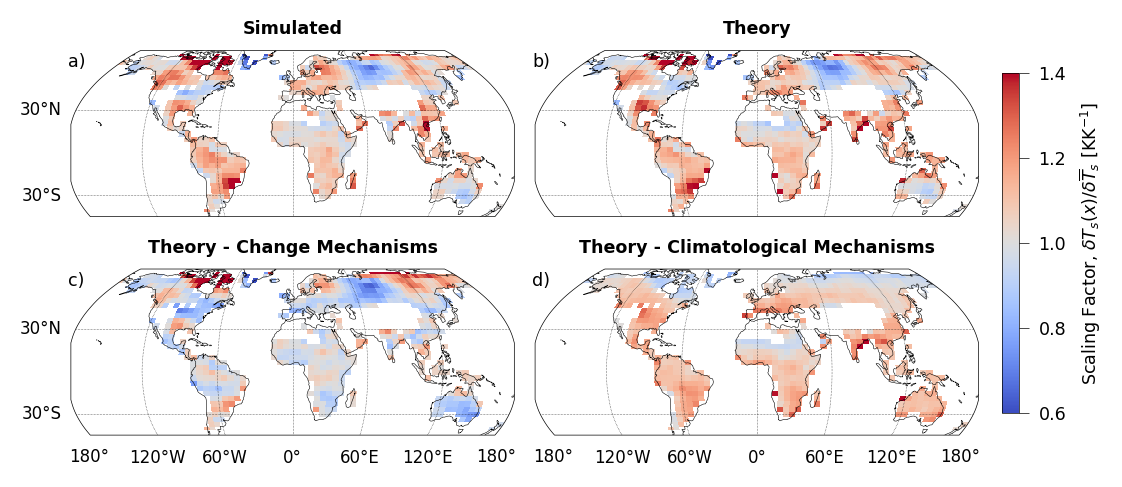

In [244]:
sf_clim = [0.6, 1.4]
fig = plt.figure(constrained_layout=True)
ax = fig.subplots(2, 2, subplot_kw={'projection': ccrs.Robinson()}, gridspec_kw={'hspace': 0}, sharex=True, sharey=True)
fig_resize(fig, width['two_col'], ar=2.4)
for i, ax_use in enumerate(ax.flatten()):
    gl = utils.initialize_ax_projection(ax_use, lat_min=lat_min, lat_max=lat_max, grid_lat=[-30, 30], return_gl=True,
                                        coastline_lw=0.2, gridline_lw=0.2)[1]
    gl.xlabel_style = {"size": gl_fontsize}
    gl.ylabel_style = {"size": gl_fontsize}
    if i <= 1:
        gl.bottom_labels = False
    if i % 2:
        gl.left_labels = False
utils.plot_contour_projection(ax[0, 0], ds_sf_use.scale_factor.where(mask_loc), cmap='coolwarm',
                              imshow=True, imshow_kwargs={'vmin': sf_clim[0], 'vmax': sf_clim[1]})
utils.plot_contour_projection(ax[0, 1], ds_sf_use.scale_factor_sum.where(mask_loc),
                              cmap='coolwarm', imshow=True, imshow_kwargs={'vmin': sf_clim[0], 'vmax': sf_clim[1]})
utils.plot_contour_projection(ax[1, 0], ds_sf_use.scale_factor_change.where(mask_loc),
                              cmap='coolwarm', imshow=True, imshow_kwargs={'vmin': sf_clim[0], 'vmax': sf_clim[1]})
im = utils.plot_contour_projection(ax[1, 1], ds_sf_use.scale_factor_anom.where(mask_loc),
                                   cmap='coolwarm', imshow=True, imshow_kwargs={'vmin': sf_clim[0], 'vmax': sf_clim[1]})

# Indicate where nl mechanisms important
# if norm_by_av:
#     for ax_use in ax.flatten():
#         plot_scatter_mask((ds_sf.lat==ds_sf_av.lat) & (ds_sf.lon==ds_sf_av.lon), ax_use, s=15, color='green')


# Indicate where non drier-get-hotter mechanism important. I think only these two have contribution of magnitude greater than 0.05.
# No negative contributions have contribution less than -0.05.
# plot_scatter_mask(ds_sf_spatial.rh_mod_anom > 1.05, ax[1, 1], s=2, marker='+', linewidths=0.3)
# plot_scatter_mask(ds_sf_spatial.p_surf_anom > 1.05, ax[1, 1], s=2, marker='x', linewidths=0.3)

label_subplots(fig, ax.flatten(), box_alpha=0, pos_y=-1, pos_x=-1)
plt.colorbar(im, ax=ax[:, 1].ravel(), label=utils.sf_label, shrink=0.85, ticks=np.arange(0.2, 2, 0.2))
ax[0, 0].set_title('Simulated', fontweight='bold')
ax[0, 1].set_title('Theory', fontweight='bold')
ax[1, 0].set_title('Theory - Change Mechanisms', fontweight='bold')
ax[1, 1].set_title('Theory - Climatological Mechanisms', fontweight='bold')
update_fontsize(fig)
plt.show()
# savefig(fig)

### Individual change mechanisms
Below I plot the individual change mechanisms responsible for the scaling factor. This is not necessary for the climatological mechanisms, as entirely dominated by drier get hotter.

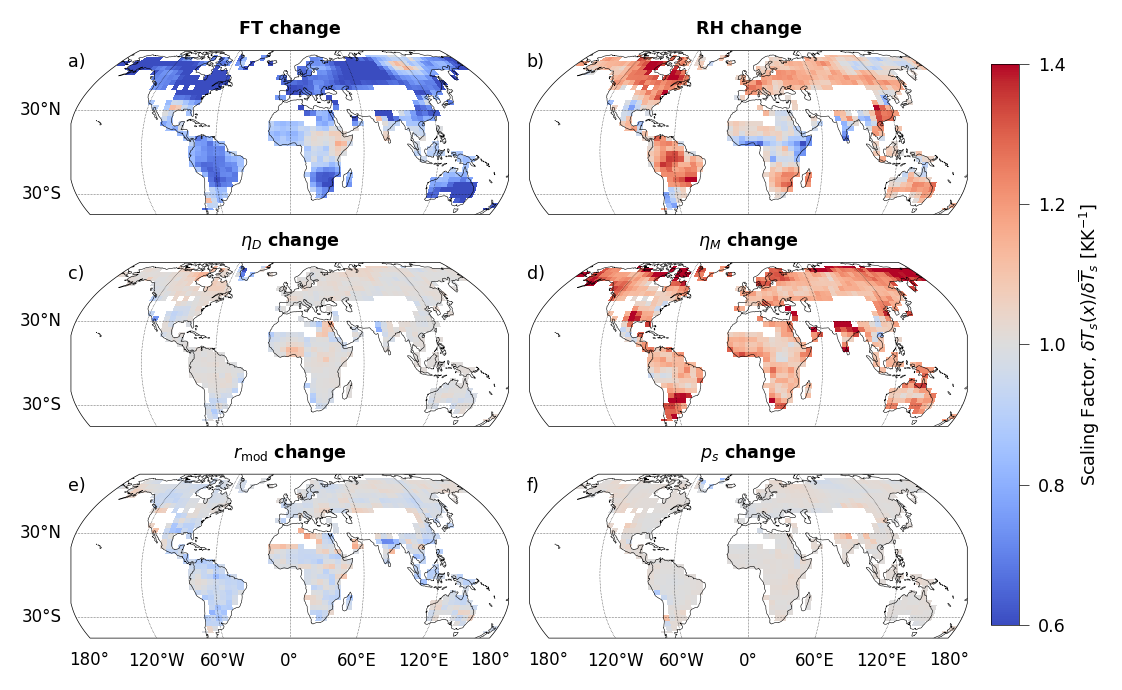

In [245]:
fig = plt.figure(constrained_layout=True)
ax = fig.subplots(3, 2, subplot_kw={'projection': ccrs.Robinson()}, gridspec_kw={'hspace': 0}, sharex=True, sharey=True)
var_order = ['temp_ft', 'rh', 'lapse_D', 'lapse_M', 'rh_mod', 'p_surf']
for i, ax_use in enumerate(ax.flatten()):
    gl = utils.initialize_ax_projection(ax_use, lat_min=lat_min, lat_max=lat_max, grid_lat=[-30, 30], return_gl=True,
                                        coastline_lw=0.2, gridline_lw=0.2)[1]
    gl.xlabel_style = {"size": gl_fontsize}
    gl.ylabel_style = {"size": gl_fontsize}
    if i <= 3:
        gl.bottom_labels = False
    if i % 2:
        gl.left_labels = False

    ax_use.set_title(utils.labels_cont[f"{var_order[i]}_change"], fontweight='bold')
    im = utils.plot_contour_projection(ax_use, ds_sf_use[f"{var_order[i]}_change"].where(mask_loc),
                                       cmap='coolwarm', imshow=True,
                                       imshow_kwargs={'vmin': sf_clim[0], 'vmax': sf_clim[1]})
    if 'rh_mod' in var_order[i]:
        continue
    # mask_nl_use = np.abs(ds_sf_spatial_num[f"{var_order[i]}_change"] - 1) > thresh_mask_nl
    # if norm_by_av:
    #     plot_scatter_mask((ds_sf.lat==ds_sf_av.lat) & (ds_sf.lon==ds_sf_av.lon), ax_use, s=15, color='green')
fig_resize(fig, width['two_col'], ar=2.5)
plt.colorbar(im, ax=ax[:, 1].ravel(), label=utils.sf_label, shrink=0.95, ticks=np.arange(0.2, 2, 0.2))
label_subplots(fig, ax.flatten(), box_alpha=0, pos_y=-1, pos_x=-1)
update_fontsize(fig)
plt.show()
# savefig(fig)

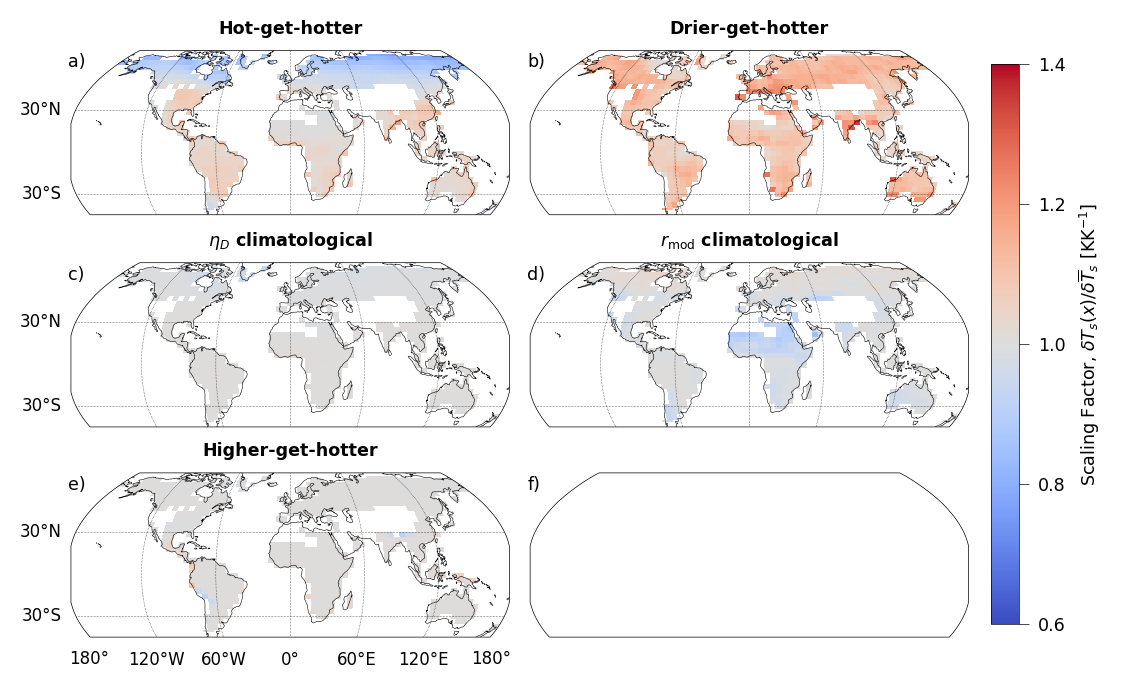

In [246]:
fig = plt.figure(constrained_layout=True)
ax = fig.subplots(3, 2, subplot_kw={'projection': ccrs.Robinson()}, gridspec_kw={'hspace': 0}, sharex=True, sharey=True)
var_order = ['temp_surf', 'rh', 'lapse_D', 'rh_mod', 'p_surf']
for i, ax_use in enumerate(ax.flatten()[:-1]):
    gl = utils.initialize_ax_projection(ax_use, lat_min=lat_min, lat_max=lat_max, grid_lat=[-30, 30], return_gl=True,
                                        coastline_lw=0.2, gridline_lw=0.2)[1]
    gl.xlabel_style = {"size": gl_fontsize}
    gl.ylabel_style = {"size": gl_fontsize}
    if i <= 3:
        gl.bottom_labels = False
    if i % 2:
        gl.left_labels = False

    ax_use.set_title(utils.labels_cont[f"{var_order[i]}_anom"], fontweight='bold')
    im = utils.plot_contour_projection(ax_use, ds_sf_use[f"{var_order[i]}_anom"].where(mask_loc),
                                       cmap='coolwarm', imshow=True,
                                       imshow_kwargs={'vmin': sf_clim[0], 'vmax': sf_clim[1]})
fig_resize(fig, width['two_col'], ar=2.5)
plt.colorbar(im, ax=ax[:, 1].ravel(), label=utils.sf_label, shrink=0.95, ticks=np.arange(0.2, 2, 0.2))
label_subplots(fig, ax.flatten(), box_alpha=0, pos_y=-1, pos_x=-1)
update_fontsize(fig)
plt.show()